In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../..']

In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve
from statistics import mean

from src.utils import utils, evaluation_utils, visualization_utils

In [16]:
tf_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240613/host_multi/few_shot_learning/fsl_non_idv_uniref90viridae_msl2048_transformer-l_6-h_8-d_1024-lr1e-4_classwise_auprc.csv")
virprobert_1_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240612/host_multi/few_shot_learning/fsl_non_idv_uniref90viridae_msl2048_virprobert_classwise_auprc.csv")
virprobert_2_output_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240620/host_multi/few_shot_learning/fsl_uniref90viridae_non_idv_lt_1percent_msl2048_virprobert_classwise_auprc.csv")

virprobert_output_scores_file_path = os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240612/host_multi/few_shot_learning/fsl_non_idv_uniref90viridae_msl2048_virprobert_output.csv")
dataset_file_path = os.path.join(os.getcwd(), "..","..", "..", "input/data/uniref90/20240131/uniref90_viridae_embl_hosts_pruned_metadata_species_vertebrates_w_seq_non_idv_lt_1percent_prevalence.csv")

output_file_paths = {
    "TF": tf_output_file_path,
    "VirProBERT-1": virprobert_1_output_file_path,
    "VirProBERT-2": virprobert_2_output_file_path
}

In [17]:
def read_output_df(output_file_paths):
    dfs = []
    for model, output_file_path in output_file_paths.items():
        df = pd.read_csv(output_file_path, index_col=0)
        df = df[df["itr"].isin(range(3))]
        df["model"] = model
        dfs.append(df)
    return pd.concat(dfs)


def compute_class_distribution(df, label_col, n, format=False):
    labels_counts = df[label_col].value_counts()
    labels_counts = labels_counts / n * 100
    labels_counts = labels_counts.to_dict()
    if format:
        labels_counts = {k: f"{k} ({v:.4f}%)" for k, v, in labels_counts.items()}
    return labels_counts

In [18]:
df = read_output_df(output_file_paths)
scores_output_df = pd.read_csv(virprobert_output_scores_file_path, index_col=0)
dataset_df = pd.read_csv(dataset_file_path)

In [19]:
df["model"].unique()

array(['TF', 'VirProBERT-1', 'VirProBERT-2'], dtype=object)

In [11]:
metadata_formatted = compute_class_distribution(dataset_df, "virus_host_name", n=47792, format=True)
metadata_formatted

{'Cyprinus carpio': 'Cyprinus carpio (0.8600%)',
 'Petroica australis': 'Petroica australis (0.8537%)',
 'Felis catus': 'Felis catus (0.6235%)',
 'Gopherus morafkai': 'Gopherus morafkai (0.6110%)',
 'Peromyscus boylii': 'Peromyscus boylii (0.5901%)',
 'Marmota flaviventris': 'Marmota flaviventris (0.5670%)',
 'Bos taurus': 'Bos taurus (0.5377%)',
 'Eptesicus fuscus': 'Eptesicus fuscus (0.5336%)',
 'Macaca mulatta': 'Macaca mulatta (0.4854%)',
 'Loxodonta africana': 'Loxodonta africana (0.4457%)',
 'Mastomys natalensis': 'Mastomys natalensis (0.4331%)',
 'Gymnorhina tibicen': 'Gymnorhina tibicen (0.4059%)',
 'Eidolon helvum': 'Eidolon helvum (0.3850%)',
 'Ailurus fulgens': 'Ailurus fulgens (0.3724%)',
 'Sparus aurata': 'Sparus aurata (0.3683%)',
 'Elephas maximus': 'Elephas maximus (0.3599%)',
 'Oryzomys sp.': 'Oryzomys sp. (0.3348%)',
 'Lates calcarifer': 'Lates calcarifer (0.3306%)',
 'Bufo bufo': 'Bufo bufo (0.3180%)',
 'Crocodylus porosus': 'Crocodylus porosus (0.3160%)',
 'Rattus n

In [12]:
metadata_unformatted = compute_class_distribution(dataset_df, "virus_host_name", n=47792, format=False)
metadata_unformatted

{'Cyprinus carpio': 0.8599765651155006,
 'Petroica australis': 0.8536993639102779,
 'Felis catus': 0.6235353197187814,
 'Gopherus morafkai': 0.610980917308336,
 'Peromyscus boylii': 0.5900569132909274,
 'Marmota flaviventris': 0.5670405088717777,
 'Bos taurus': 0.5377469032474054,
 'Eptesicus fuscus': 0.5335621024439237,
 'Macaca mulatta': 0.48543689320388345,
 'Loxodonta africana': 0.4456812855708068,
 'Mastomys natalensis': 0.4331268831603616,
 'Gymnorhina tibicen': 0.4059256779377301,
 'Eidolon helvum': 0.38500167392032136,
 'Ailurus fulgens': 0.37244727150987617,
 'Sparus aurata': 0.36826247070639434,
 'Elephas maximus': 0.35989286909943086,
 'Oryzomys sp.': 0.33478406427854035,
 'Lates calcarifer': 0.33059926347505864,
 'Bufo bufo': 0.3180448610646133,
 'Crocodylus porosus': 0.31595246066287247,
 'Rattus norvegicus': 0.305490458654168,
 'Hypsugo savii': 0.305490458654168,
 'Equus caballus': 0.305490458654168,
 'Dipodomys merriami': 0.30339805825242716,
 'Crocodilurus amazonicus': 

In [13]:
classes = list(metadata_unformatted.keys())
classes

['Cyprinus carpio',
 'Petroica australis',
 'Felis catus',
 'Gopherus morafkai',
 'Peromyscus boylii',
 'Marmota flaviventris',
 'Bos taurus',
 'Eptesicus fuscus',
 'Macaca mulatta',
 'Loxodonta africana',
 'Mastomys natalensis',
 'Gymnorhina tibicen',
 'Eidolon helvum',
 'Ailurus fulgens',
 'Sparus aurata',
 'Elephas maximus',
 'Oryzomys sp.',
 'Lates calcarifer',
 'Bufo bufo',
 'Crocodylus porosus',
 'Rattus norvegicus',
 'Hypsugo savii',
 'Equus caballus',
 'Dipodomys merriami',
 'Crocodilurus amazonicus',
 'Tarsiger cyanurus',
 'Chelonia mydas',
 'Mus musculus',
 'Rhinolophus ferrumequinum',
 'Ovis aries',
 'Tursiops aduncus',
 'Tadarida brasiliensis',
 'Anas superciliosa',
 'Pteropus scapulatus',
 'Heloderma suspectum',
 'Squalius cephalus',
 'Oryctolagus cuniculus',
 'Coendou prehensilis',
 'Anas castanea',
 'Grus japonensis',
 'Amazona oratrix',
 'Callorhinus ursinus',
 'Phylloscopus inornatus',
 'Macaca fuscata',
 'Phrynocephalus erythrurus',
 'Hoplobatrachus rugulosus',
 'Pero

In [14]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

<Figure size 432x288 with 0 Axes>

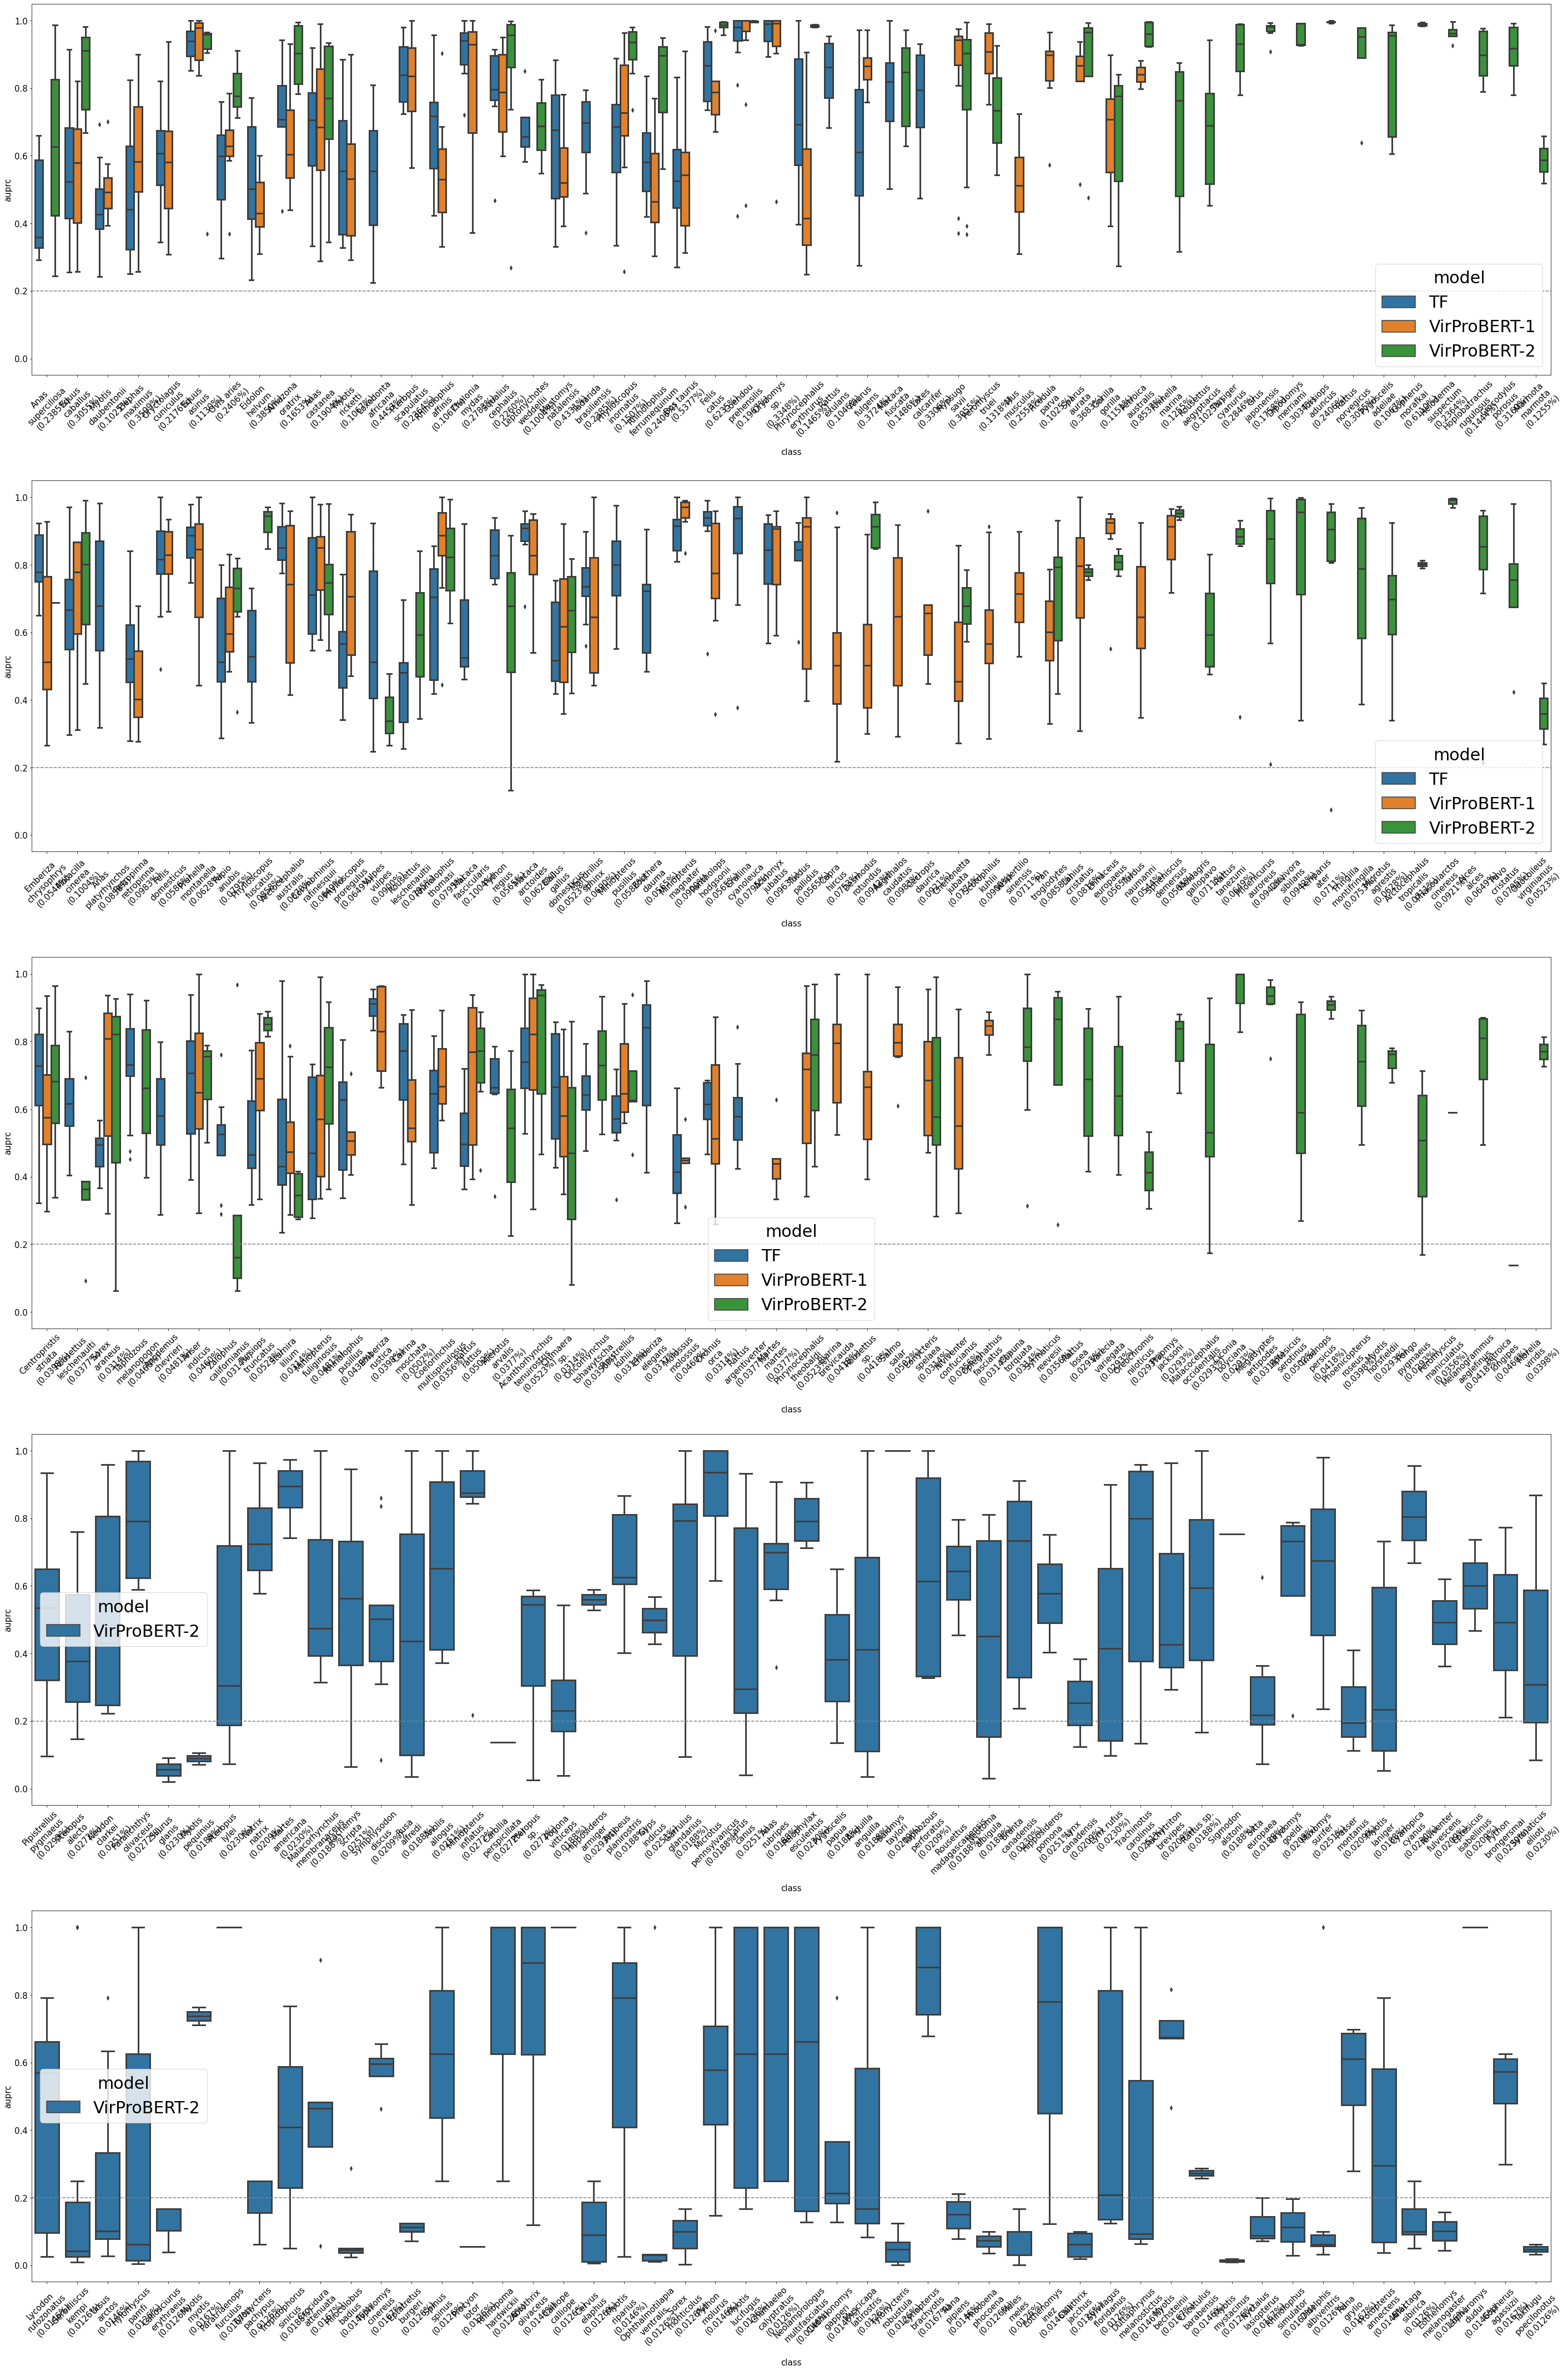

In [22]:
# plt.rcParams['xtick.labelsize'] = 15
# plt.rcParams['ytick.labelsize'] = 15


# DEFAULT_FIGURE_CONFIG = {
#     "figsize": (16, 8),
#     "xtick.labelsize": 15,
#     "ytick.labelsize": 15    
# }

plt.rcParams['figure.autolayout'] = True
plt.clf()
fig, axs = plt.subplots(5, 1, figsize=(40, 60), sharey=True)
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})


df = df.replace({"class": metadata_formatted})
classes = list(metadata_formatted.values())
bins = get_uniformly_divided_position_bins(list(classes), 5)

for i in range(5):
    sns.boxplot(data=df[df["class"].isin(bins[i])],  y="auprc", x="class", ax=axs[i], orient="v", hue="model",
                linewidth=3,)
    #sns.stripplot(data=df[df["class"].isin(bins[i])], x="class", y="auprc", ax=axs[i])
    visualization_utils.wrap_ticklabels(axs[i], axis="x")
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].axhline(0.2, color="gray", linestyle="--")

plt.show()

<Figure size 432x288 with 0 Axes>

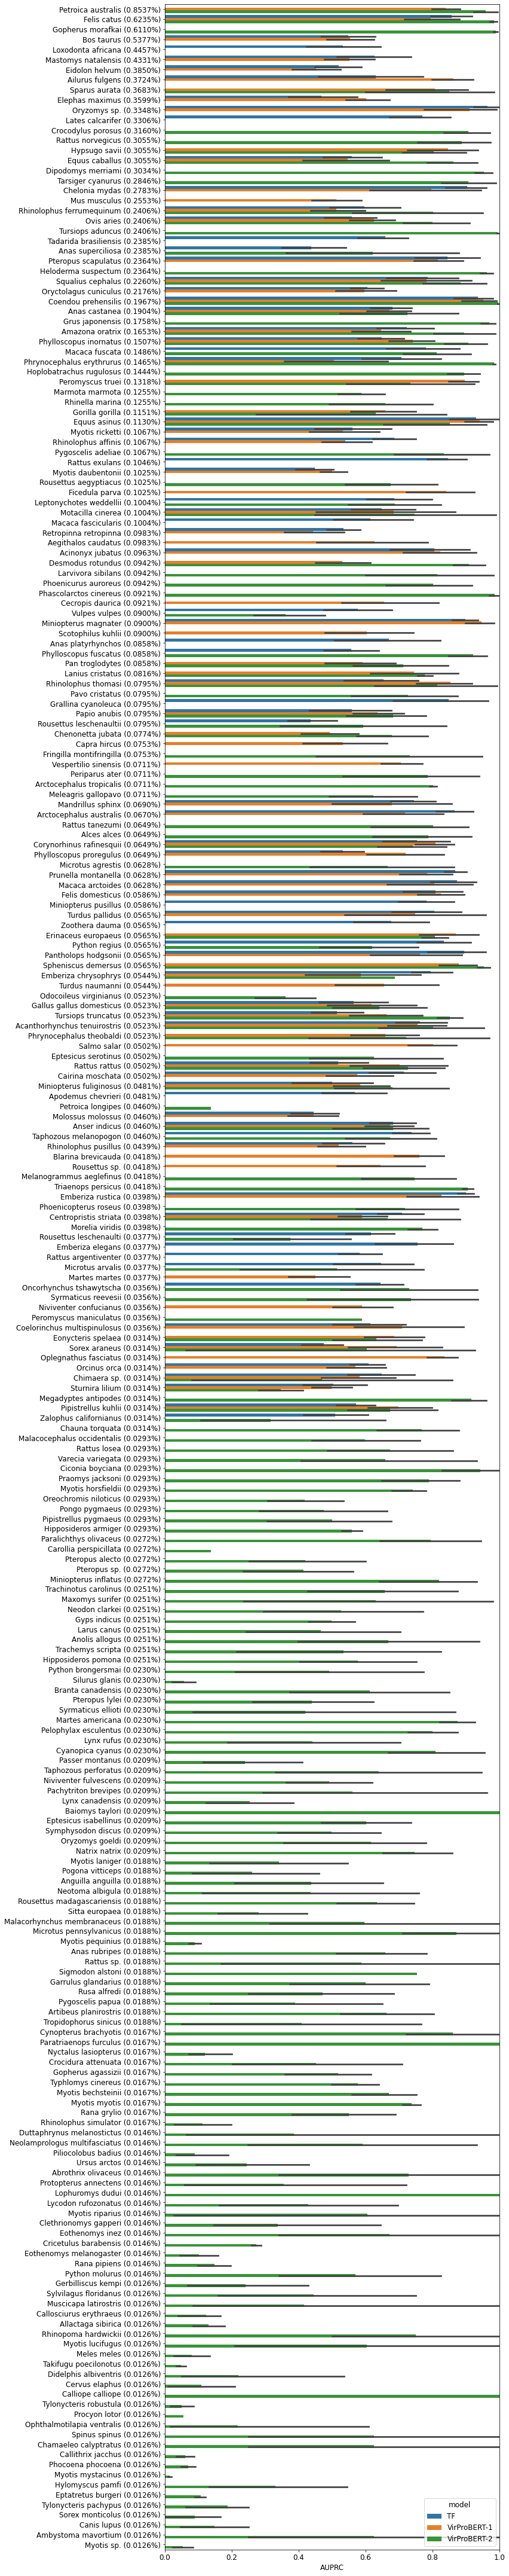

In [32]:
plt.rcParams['figure.autolayout'] = True
plt.clf()
fig, axs = plt.subplots(1, 1, figsize=(12, 60), sharey=True)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams.update({'font.size': 12})

df = read_output_df(output_file_paths)
df_classes = list(df["class"].unique())

metadata_formatted = {k:v for k, v in metadata_formatted.items() if k in df_classes}


df = df.replace({"class": metadata_formatted})
classes = list(metadata_formatted.values())
bins = get_uniformly_divided_position_bins(list(classes), 1)

for i in range(1):
    sns.barplot(data=df[df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs, orient="h", hue="model", #facecolor="#3172FF", 
                linewidth=3, order=classes)
    #sns.stripplot(data=df[df["class"].isin(bins[i])], x="class", y="auprc", ax=axs[i])
    # visualization_utils.wrap_ticklabels(axs, axis="y")
    #axs.tick_params(axis='x', rotation=45)
    axs.set_xlim(0, 1)
    axs.set_ylabel("")
    axs.set_xlabel("AUPRC")
    # axs.axhline(0.2, color="gray", linestyle="--")

plt.show()
    #visualization_utils.view(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp/few_shot_learning/fsl_nonidv_uniref90viridae_msl2048.pdf"))

In [16]:
len(list(metadata_formatted.values()))

83